---
# Linear Regression Implementation
The start of every machine learning project begins the same way: 
- Data Inspection
- Data Visualization
- Data Regularization
- Model implementation

Our [data](https://archive.ics.uci.edu/ml/datasets/Real+estate+valuation+data+set) is a set of real estate valuates from New Taipei City,Taiwan. We will first load a dataframe and inspect the data

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn import linear_model


# Load data
data_df = pd.read_csv("Real Estate.csv")

# initial inspection of the data

print("Shape is: ", data_df.shape)
data_df[:10]


Shape is:  (414, 8)


,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1
5,6,2012.667,7.1,2175.03000,3,24.96305,121.51254,32.1
6,7,2012.667,34.5,623.47310,7,24.97933,121.53642,40.3
7,8,2013.417,20.3,287.60250,6,24.98042,121.54228,46.7
8,9,2013.500,31.7,5512.03800,1,24.95095,121.48458,18.8
9,10,2013.417,17.9,1783.18000,3,24.96731,121.51486,22.1


---
## Visualization

The dataset has 6 features and 1 output. We cannot visualize 6-dimensional data, however we can inspect each feature against the output to identify any important correlations between the features. 

Number of columns: 8


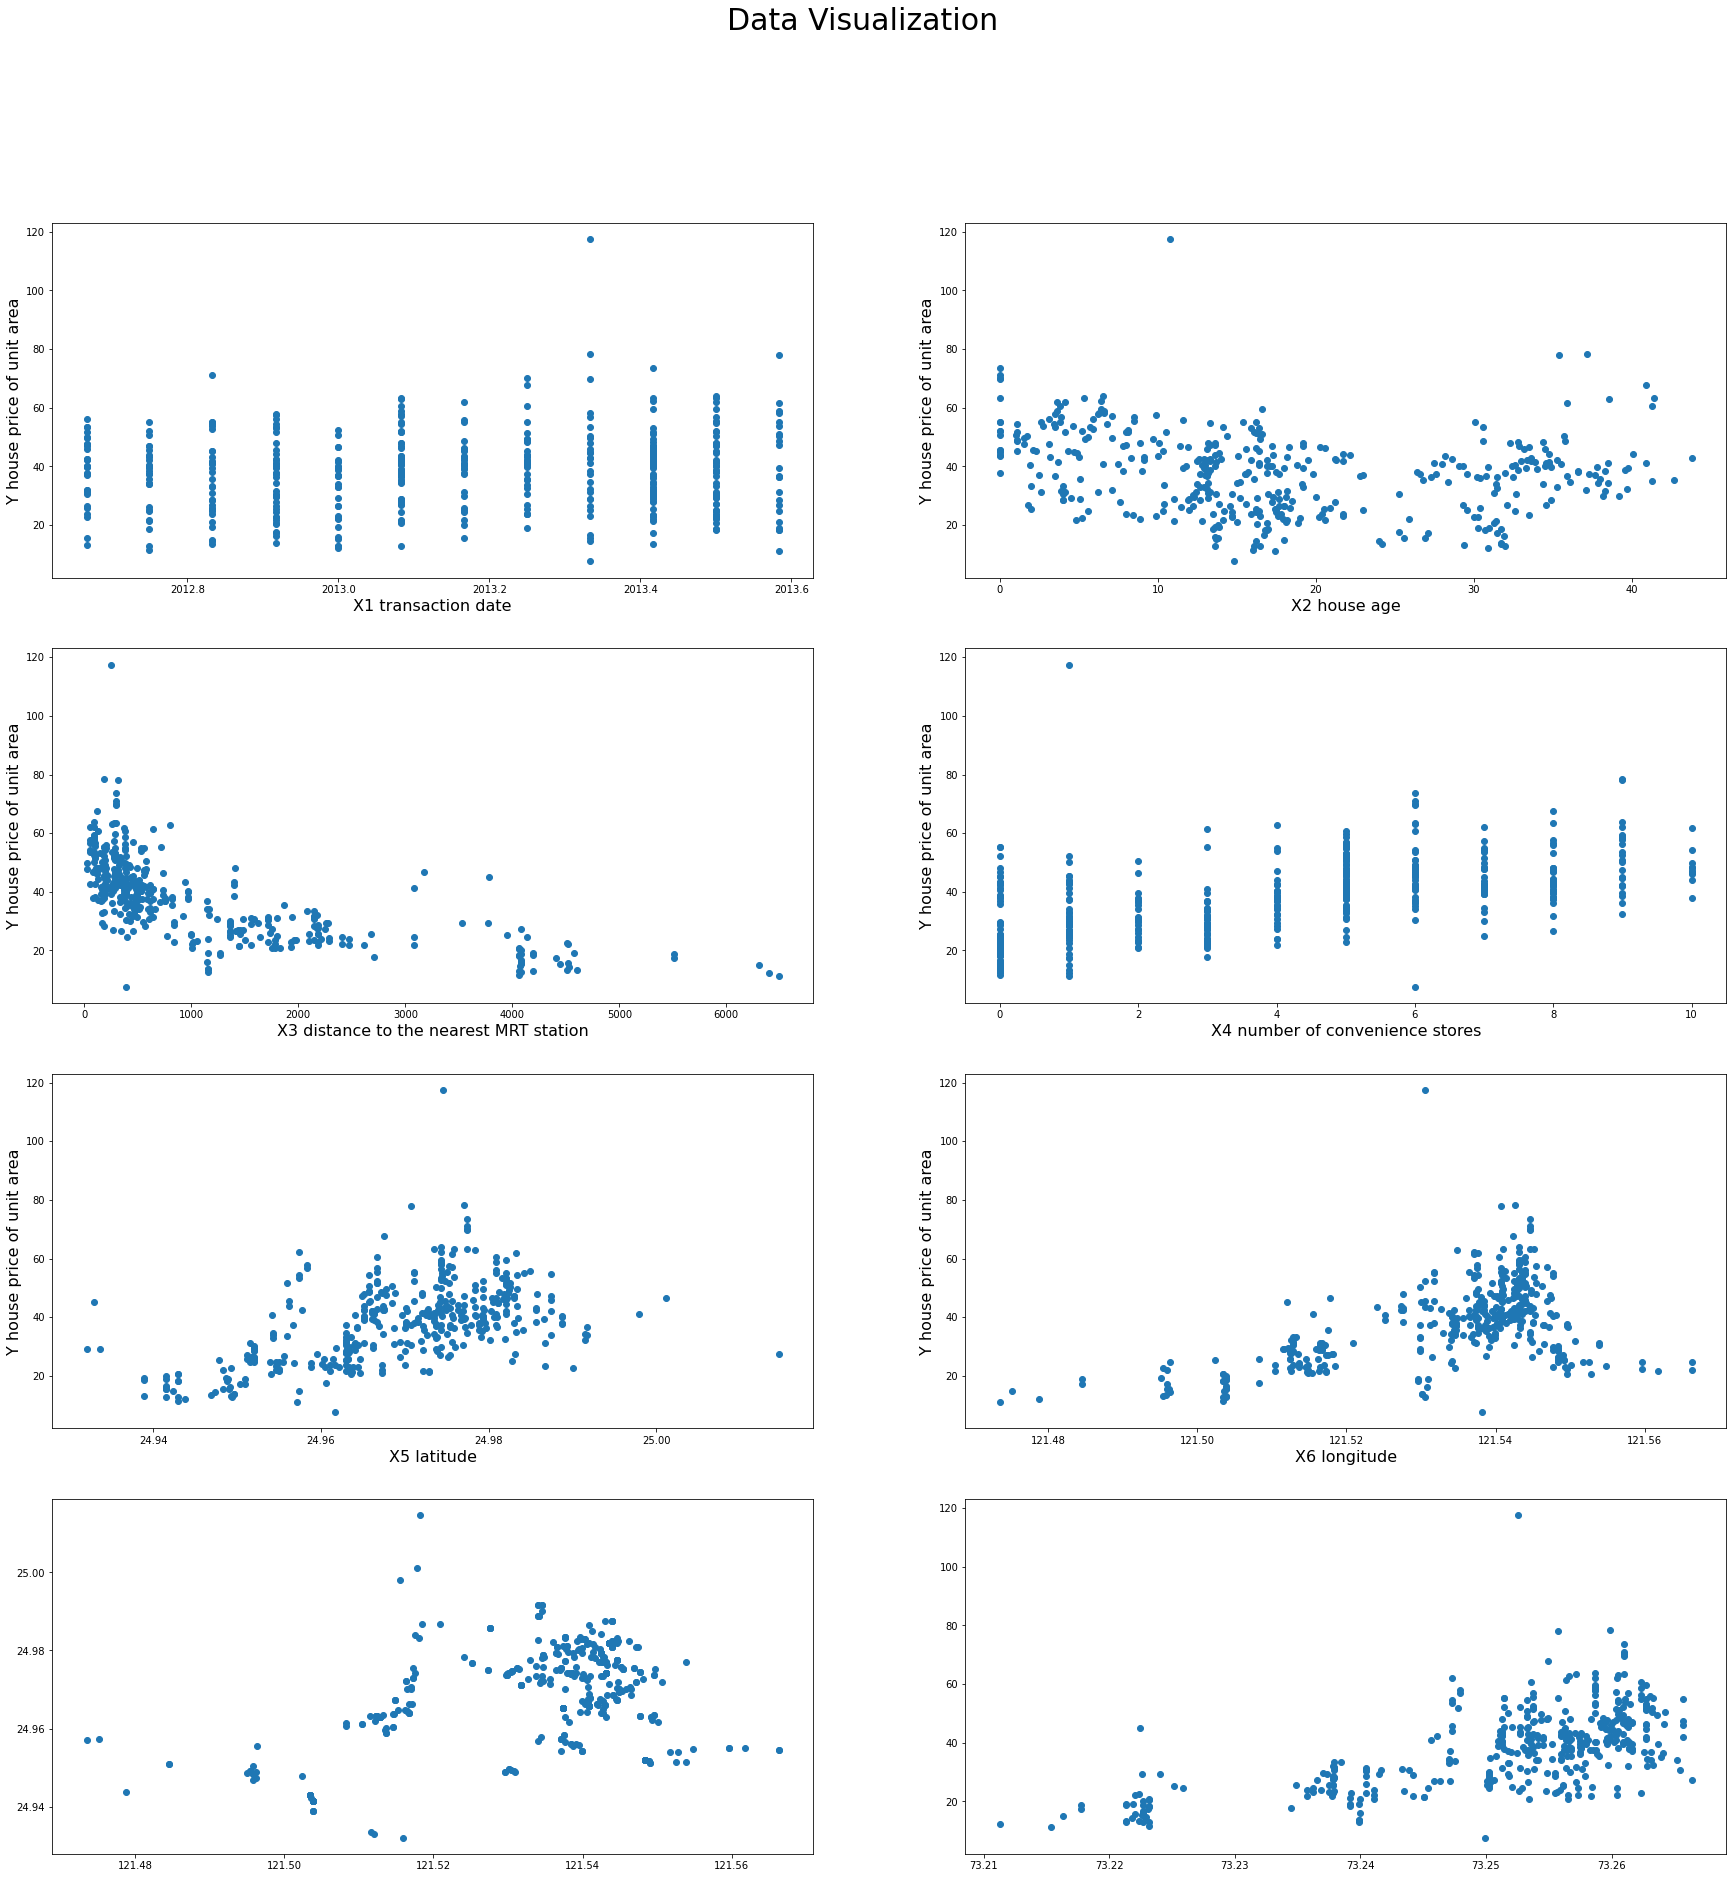

In [20]:
print(f"Number of columns: {data_df.shape[1]}")

# Plot data to identify trends
fig, axs = plt.subplots(4,2)

# Need a big figure
fig.set_size_inches(30, 30)

# Label figure
fig.suptitle("Data Visualization", fontsize = 30)
label = data_df.columns[-1]

i = 0
j = 0

# Plot each feature against the price/sqft
for feature in data_df.columns[1:-1]:
    axs[i,j].scatter(data_df[feature], data_df[label])
    axs[i,j].set_xlabel(feature, fontsize = 16)
    axs[i,j].set_ylabel(label, fontsize = 16)

    # These are not the droids you're looking for
    j += 1
    if j > 1:
        j = 0
        i += 1
    if i > 2:
        i = 0

# Plot by long/lat to see how the houses are arranged in the city    
axs[3,0].scatter(data_df["X6 longitude"], data_df["X5 latitude"])

# Experiment with averaging long/lat and ploting against housing per sqft
axs[3,1].scatter((data_df["X5 latitude"] + data_df["X6 longitude"])/2, data_df["Y house price of unit area"])

Longitude and latitude are combined together into a coordinate. While each seperately may yeild some information about the potential output, a combination of the two should give much more information about the output. We can plot longitude and latitude against the output using a 3-d plot. 

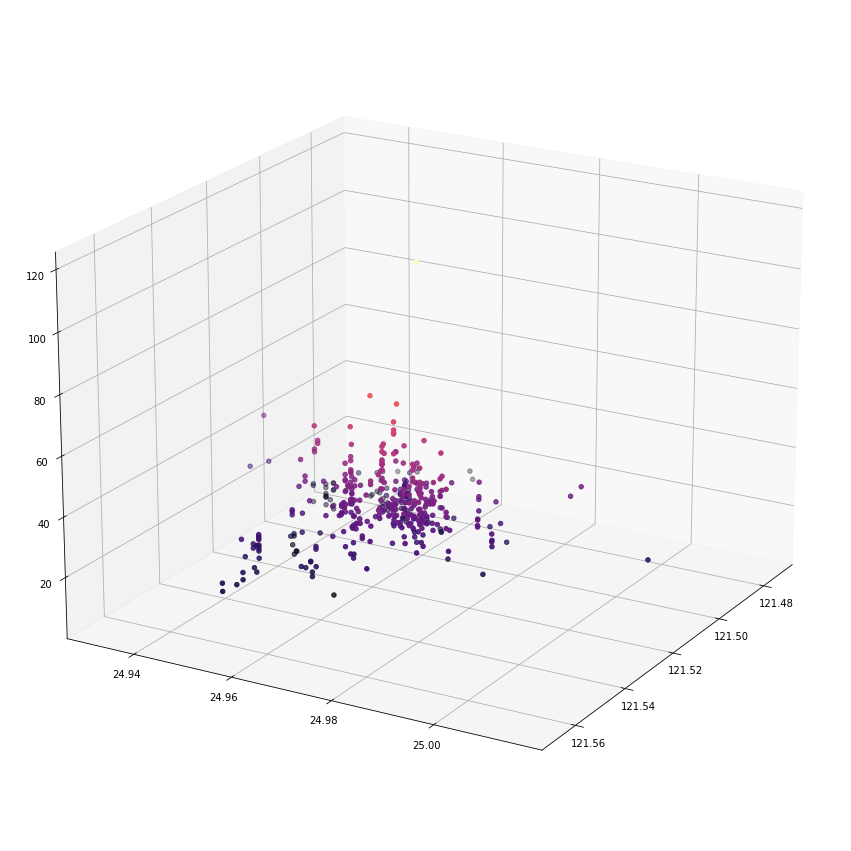

In [21]:
# Visualize a 3D plot of long/lat and housing price

fig = plt.figure(figsize = (15,30))
ax = fig.add_subplot(projection = '3d')
ax.scatter3D(data_df["X6 longitude"], data_df["X5 latitude"], data_df["Y house price of unit area"], c = data_df["Y house price of unit area"], cmap = 'magma')
ax.view_init(20, 30)


No single feature is strongly correlated with the observed outputs, however there are loose assosiciations that may allow us to find a linear association between the features and outputs. 

---

## Data Regularization
The next step in our project is to regularize the data. This reduces the spread of each features and reduces the range between features. I.e. if one feature is number of bedrooms (1-5), and another is total square footage (1000 - 5000), the difference in magnitude of each feature is enormous. By regularizing the data, we develop simlar scales between the data. 

In this step, we will also split the data into features and outputs and shuffle and divide the data into a training set and test set.

We will regularize the data using the equation:
$
\Large Z = \dfrac{\bar{X} - \mu}{\sigma}
$

In [22]:
# break down data for linear regression

# Regularization: z = (sample - mu)/sigma

# Convert dataframe to numpy array
data = data_df.to_numpy()

# toss the 'No' column, just lists the number of houses not a real datapoint
data = data[:,1:]

# Regularize features, not labels
x_data = data[:,:-1]

# find averages of each feature
mu = x_data.sum(axis=0)/data.shape[0]

# Calculate standard deviation of each feature
sigma = np.std(x_data, axis=0)

# regularize
r_data = (x_data-mu)/sigma

# Append column of 1s for bias
r_data = np.c_[np.ones(r_data.shape[0]), r_data]


---
## Splitting Data

Next, we must partition the data so we can train on a subset, then test and verify our model with a partition the model was not tuned on. This enhances our ability to know if our model has overfit the training data and understand the accuracy of future predictions. here, we will partition 2/3rds of the data to train on, and 1/3 of the data to test and verify on. 

In [23]:
# Split data into x = features and y = labels
y = data[:,-1]

X = r_data
#X = X[:,1:]
# Split into train, validate, test data. Shuffle data for better results
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, shuffle=True, random_state=42)


---
## Train the Model

We will use two methods to train our linear regression model: gradient descent and the normal equation. 

### Gradient Descent
Gradient descent is an iterative algorithm for updating the weights applied to the feature vector. Random weights are applied the first iteration. A prediction is calcuated following $\hat{y} = X^T\theta$ and the error is found using $(\hat{y} - y)$. gradient step is calculated with the equation $\triangledown\theta = \frac{2}{n}\sum_{i=1}^n{X^T(\hat{y} - y)}$. 

The weights are then updated using the equation $\theta_{i} = \theta_{i-1} - \alpha\triangledown\theta$. The $\alpha$ is the learning rate which tempers the steps of the gradients to prevent skipping over the minimum. Setting an alpha too low can prevent the algorithm from reaching the minimum in the iteration set, and an alpha too high risks skipping the minimum. The scenarios are shown below:

![Gradient Descent](Alphas2.png)

### Normal Equation
Gradient descent for linear regression is inefficient and can be computationally expensive as computation time increases exponenetially with the number of features. The optimal weights can be calculated directly using the equation:
$
\hat{\theta} = (X^TX)^{-1}(X^Ty)
$ 

This value of theta minimizes the convex equation $(y^i - \theta^Tx^i)^2$ directly regardless of the number of features included in the data. 

We find $\theta$ using both gradient descent and the normal equation for comparisson. 

Text(150, 30, 'MSE: \nGradient Descent: 71.49\nNormal Eq: 71.49')

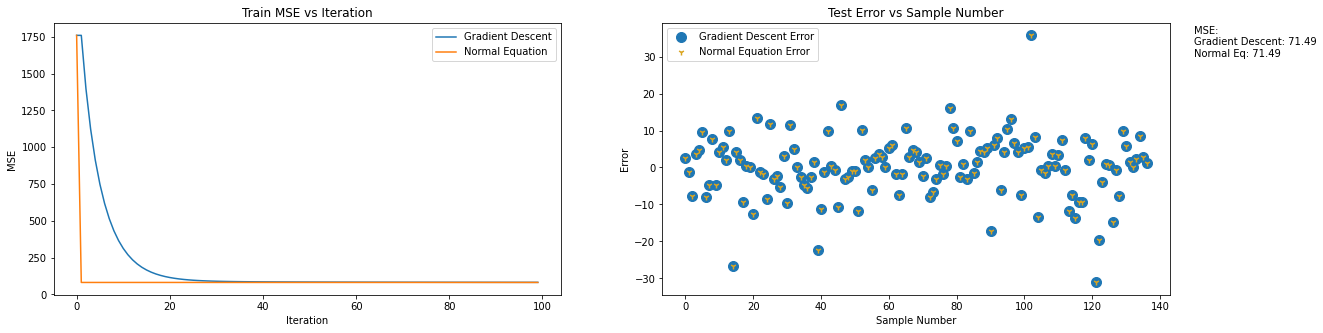

In [24]:
alpha = .002
gMSE_all = []
nMSE_all = []
i_all = []

# initialize weights
theta = np.random.randn(X_train.shape[1])*np.sqrt(2)
y_hat = X_train @ theta
gMSE = (1/X_train.shape[0])*sum((y_hat - y_train)**2)
nMSE = (1/X_train.shape[0])*sum((y_hat - y_train)**2)
gMSE_all.append(gMSE)
nMSE_all.append(nMSE)

# Save initial errors


for i in range(1000):
    # make prediction
    y_hat = X_train @ theta

    # calculate cost
    gMSE = (1/X_train.shape[0])*sum((y_hat - y_train)**2)
    # collect data
    gMSE_all.append(gMSE)
    i_all.append(i)

    # Gradient Descent
    delta = (2/X_train.shape[0])*(X_train.T @ (y_hat - y_train))

    # update
    theta = theta - .05*delta

    
    # theta_hat does not need to be here, used to show instant best calculation on graph
    theta_hat = np.linalg.inv(X_train.T.dot(X_train)).dot(X_train.T).dot(y_train)
    y_hat = X_train @ theta_hat
    nMSE = (1/X_train.shape[0])*sum((y_hat - y_train)**2)
    nMSE_all.append(nMSE)

# Normal Equation
theta_hat = np.linalg.inv(X_train.T.dot(X_train)).dot(X_train.T).dot(y_train)


gy_hat = X_test @ theta
ny_hat = X_test @ theta_hat

# calculate average squared error
gMSE = (1/X_test.shape[0])*sum((gy_hat - y_test)**2)    
nMSE = (1/X_test.shape[0])*sum((ny_hat - y_test)**2)   

fig, ax = plt.subplots(1,2, figsize = (20,5))

# Plot the first 100 to highlight curve
ax[0].plot(i_all[:100], gMSE_all[:100], label = "Gradient Descent")
ax[0].plot(i_all[:100], nMSE_all[:100], label = "Normal Equation")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("MSE")
ax[0].set_title("Train MSE vs Iteration")
ax[0].legend()

#predict on test data
ax[1].scatter(range(X_test.shape[0]), gy_hat - y_test, label = "Gradient Descent Error", s = 100)
ax[1].set_xlabel("Sample Number")
ax[1].set_ylabel("Error")
ax[1].set_title("Test Error vs Sample Number")
ax[1].scatter(range(X_test.shape[0]), ny_hat - y_test, label = "Normal Equation Error", c = 'goldenrod', marker = '1')
ax[1].legend()

text = "MSE: \n" + "Gradient Descent: " + str(round(gMSE,2)) + "\n" + "Normal Eq: " + str(round(nMSE,2))
ax[1].text(150,30, text)




---
# Results Visualization

Now that our model has been trained, we van see how well our predictions align with the actual results of the test sets. We can deconstruct the feature vector and plot the input featurs vs the predictions and the actual results so see how well we perform. 

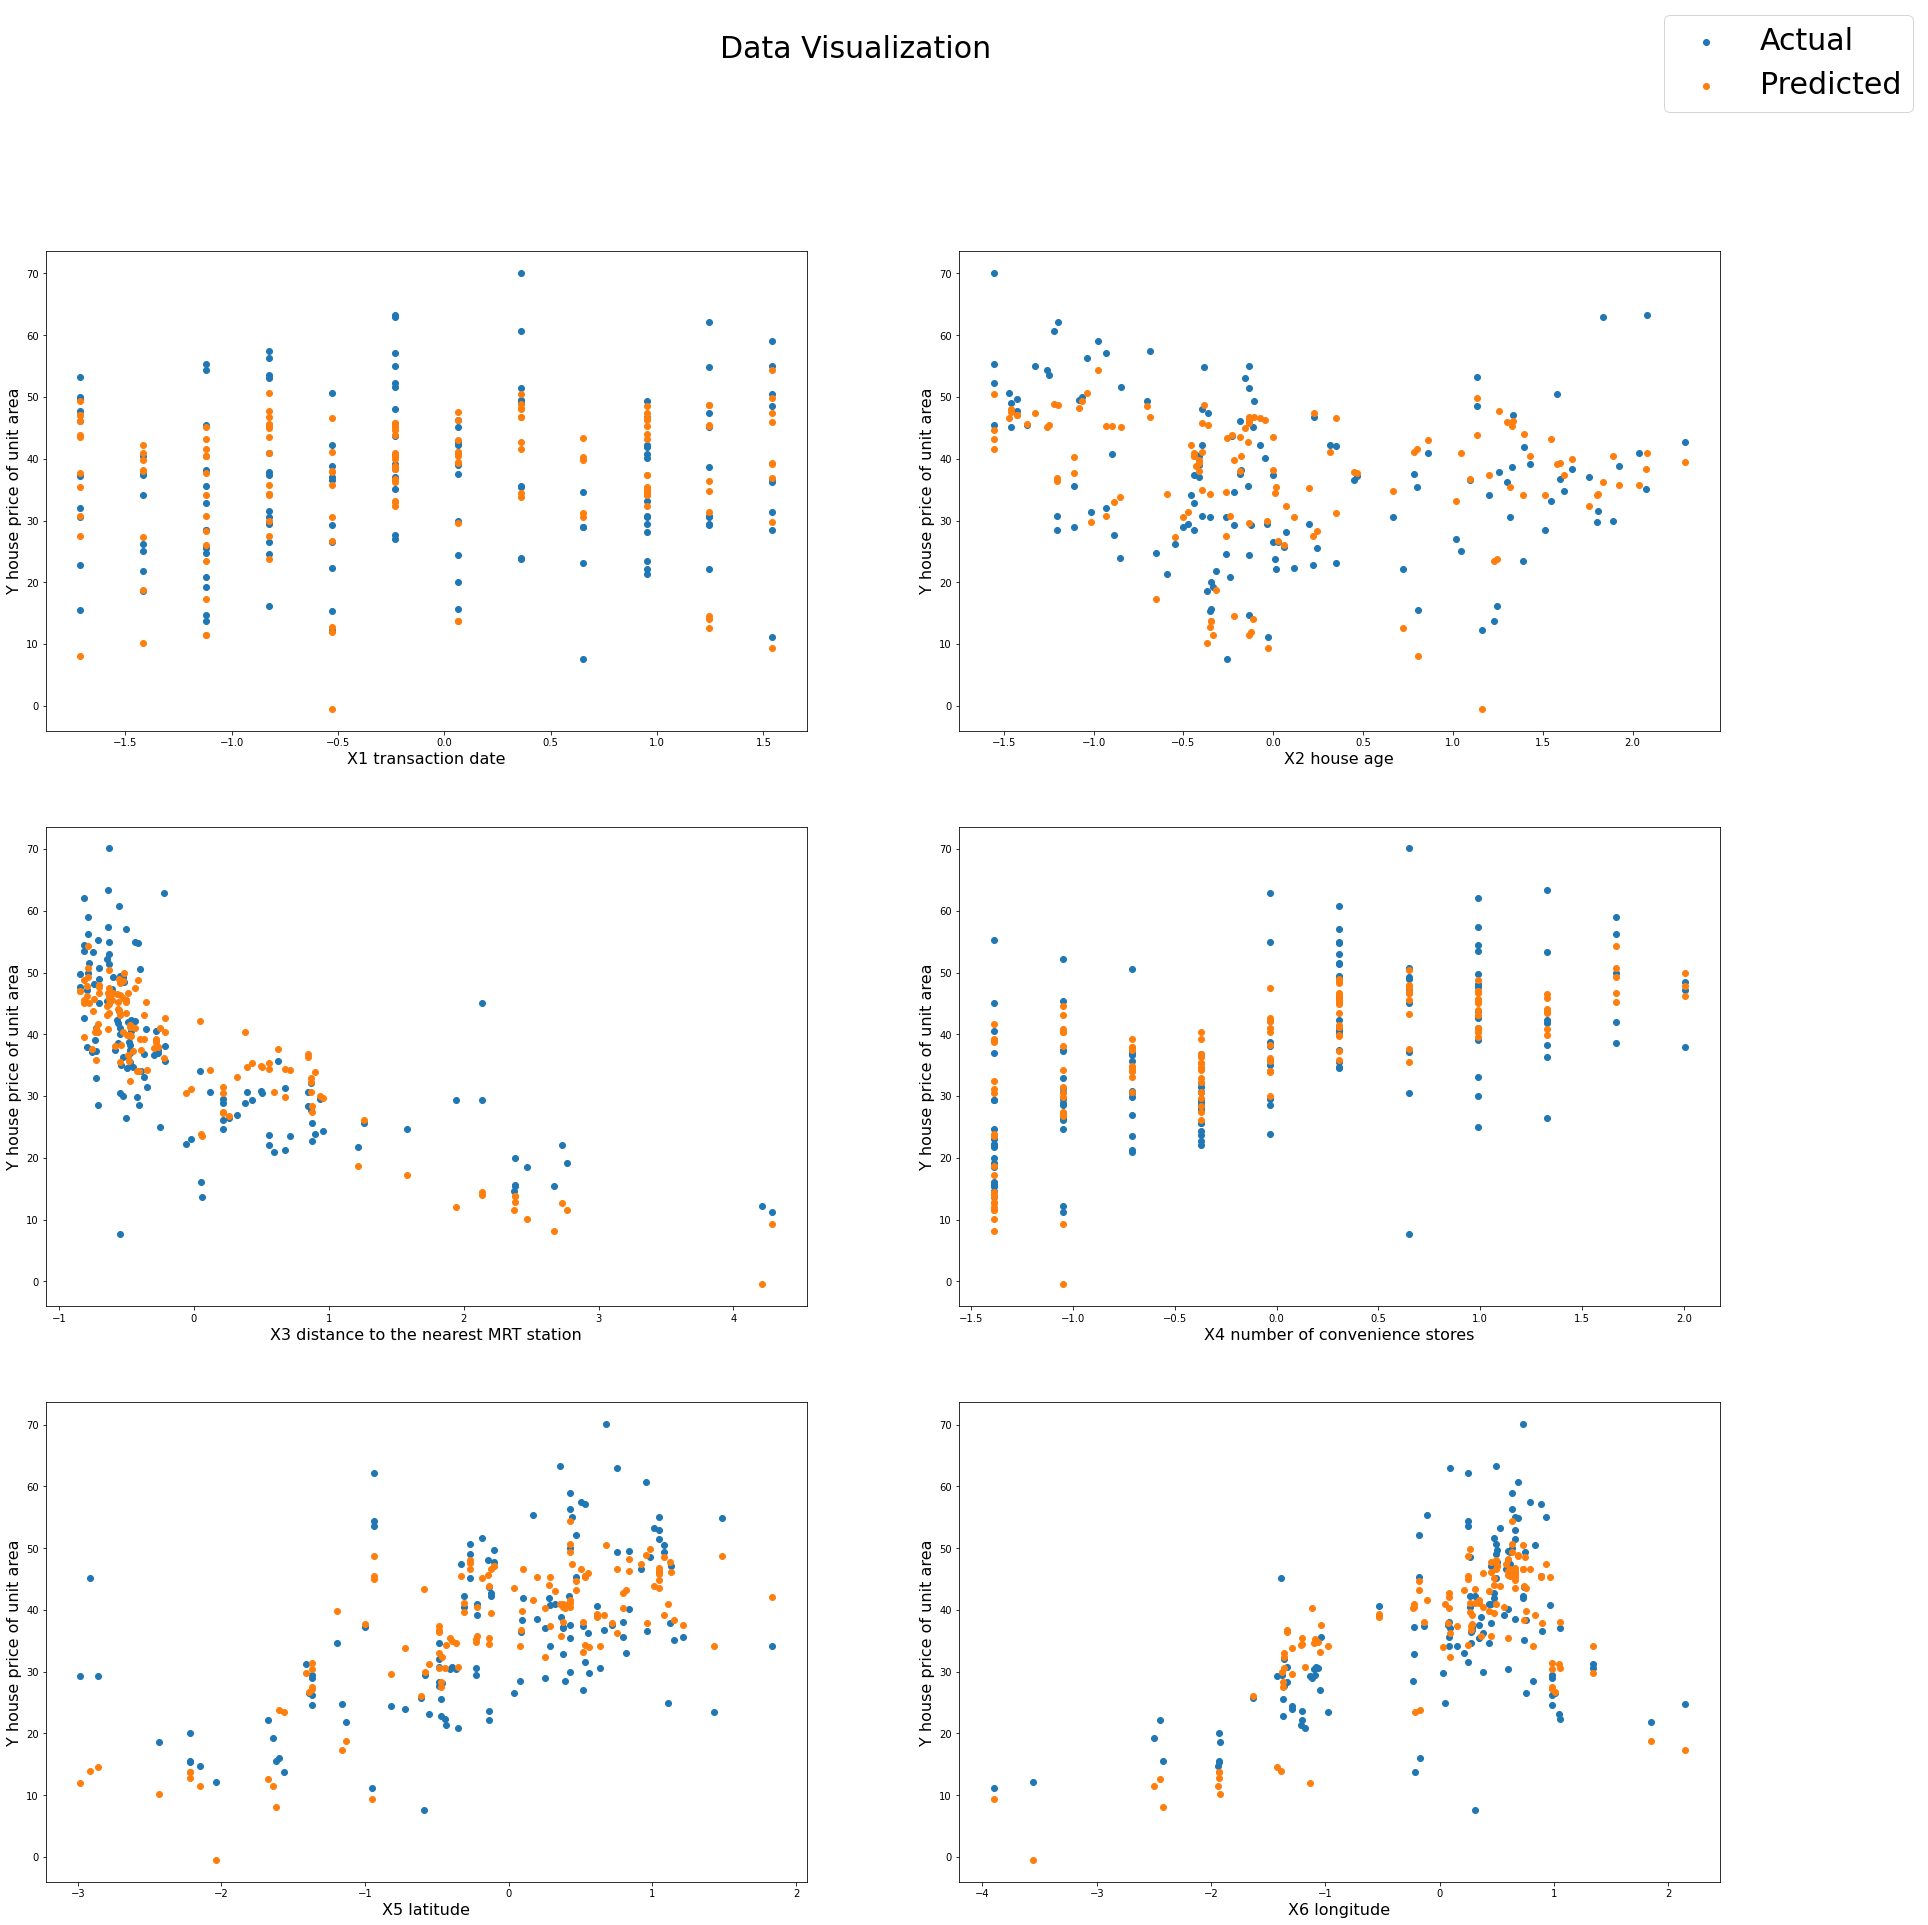

In [25]:
# Plot data to identify trends
fig, axs = plt.subplots(3,2)

# Need a big figure
fig.set_size_inches(30, 30)

# Label figure
fig.suptitle("Data Visualization", fontsize = 30)
label = y_test

u=0
v=0

# Plot each feature against the price/sqft
for i in range(1, X_test.shape[1]):
    axs[v,u].scatter(X_test[:,i], label)
    axs[v,u].scatter(X_test[:,i], ny_hat)
    axs[v,u].set_xlabel(data_df.columns[i], fontsize = 16)
    axs[v,u].set_ylabel(data_df.columns[-1], fontsize = 16)

    # These are not the droids you're looking for
    u += 1
    if u > 1:
        u = 0
        v += 1
    if v > 2:
        v = 0

fig.legend(["Actual", "Predicted"], fontsize = 30)


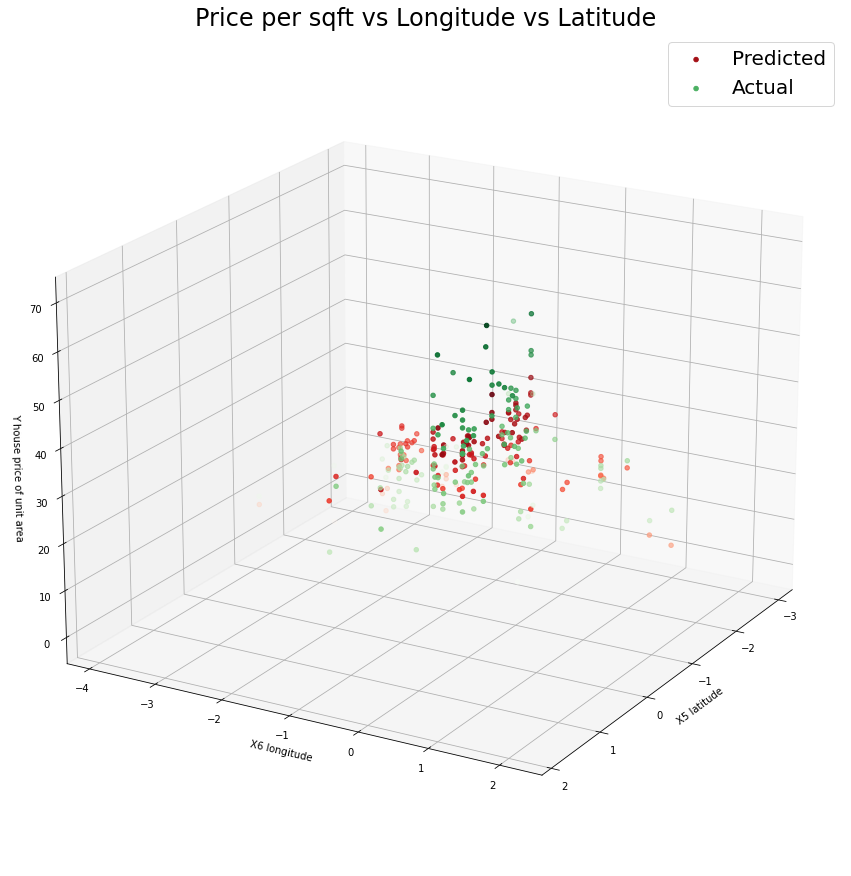

In [26]:
# Visualize a 3D plot of long/lat and housing price

fig = plt.figure(figsize = (15,30))
ax = fig.add_subplot(projection = '3d')

ax.scatter3D(X_test[:,5], X_test[:,6], ny_hat, c = ny_hat, cmap = 'Reds', label = "Predicted")
ax.scatter3D(X_test[:,5], X_test[:,6], y_test, c = y_test, cmap = 'Greens', label = "Actual")

ax.set_xlabel(data_df.columns[5])
ax.set_ylabel(data_df.columns[6])
ax.set_zlabel(data_df.columns[-1])

ax.set_title("Price per sqft vs Longitude vs Latitude", fontsize = 24)
ax.legend(fontsize = 20)
ax.view_init(20, 30)

Linear regression attempts to describe a linear relationship within the data. Variance and outliers greatly affect the ability of a linear regression algorithm's accuracy. Above, we can see the algorithm's predictions are concentrated on the bulk of the data and the errors increase the further it is from the highest concentration. 

---

# Error Analysis
There are several ways to judge the efficacy of reggression algorthims. Three of the most prominent are [Mean Squared Error](https://en.wikipedia.org/wiki/Mean_squared_error), [Mean Absolute Error](https://en.wikipedia.org/wiki/Mean_absolute_error), and [$R^2$ Error](https://en.wikipedia.org/wiki/Coefficient_of_determination).

## Mean Squared Error
$
MSE = \frac{1}{n}\sum_{i=1}^{n}(\hat{y} - y)^2
$

Mean Squared Error assesses the quality of a predictor my measuring the average squared difference between the true and predicted values. The MSE incorporates both the variance and bias of the estimator. The best possible score is 0.

## Mean Absolute Error

$
MAE = \frac{1}{n}\sum_{i=1}^{n}|\hat{y} - y|
$

While MAE is closely related to MSE, it provides the average distance between the predicted cooridnate and true coordinate. The best possible score is 0.

## $R^2$ Error

$
R^2  = 1-\frac{\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}{\sum_{i=1}^{n}(y_i - \bar{y})^2}
$

The $R^2$ error represents the proportion of variance that has been explained by the variables in the model and is essentially how well the line fits the data. The highest possible score of 1 means the model always predicts the correct output. 

In [27]:
# MSE
y_hat = X_test @ theta_hat
MSE = (1/X_test.shape[0])*sum((y_hat - y_test)**2)
print(f"Mean Squared Error: {np.round(MSE,2)}")

# MAE
MAE = (1/X_test.shape[0])*sum(np.abs((y_hat - y_test)))
print(f"Mean Absolute Error: {np.round(MAE,2)}")

# r^2
R2 = sk.metrics.r2_score(y_test, y_hat)
print(f"R-square: {np.round(R2,2)}")




Mean Squared Error: 71.49
Mean Absolute Error: 6.09
R-square: 0.55


---
# Variations
Multiple linear regression algorithms attempt to overcome the major issues simple linear regression suffers from. Three of the variations are *ridge regression*, *LASSO regression*, and *elastic net*.

### LASSO Regression
[LASSO](https://www.statisticshowto.com/lasso-regression/) - or Least Absolute Shrinkage and Selection Operator - regression uses "shrinkage" where data values are shrunk towards the mean. This algorithm is useful in feature selection and applies a "penalty" to features that do not benefit the prediction

### Ridge Regression
[Ridge](https://www.mygreatlearning.com/blog/what-is-ridge-regression/) regression compensates for large variation in the input data. Ridge regression includes a "penalty" term $\lambda$ that shrinks weight of $\theta$

### Elastic Net
[Elastic Net](https://en.wikipedia.org/wiki/Elastic_net_regularization) Regression is a combination of LASSO and Ridge Regression that adjusts both the weight of features and the weight of the updated $\theta$.

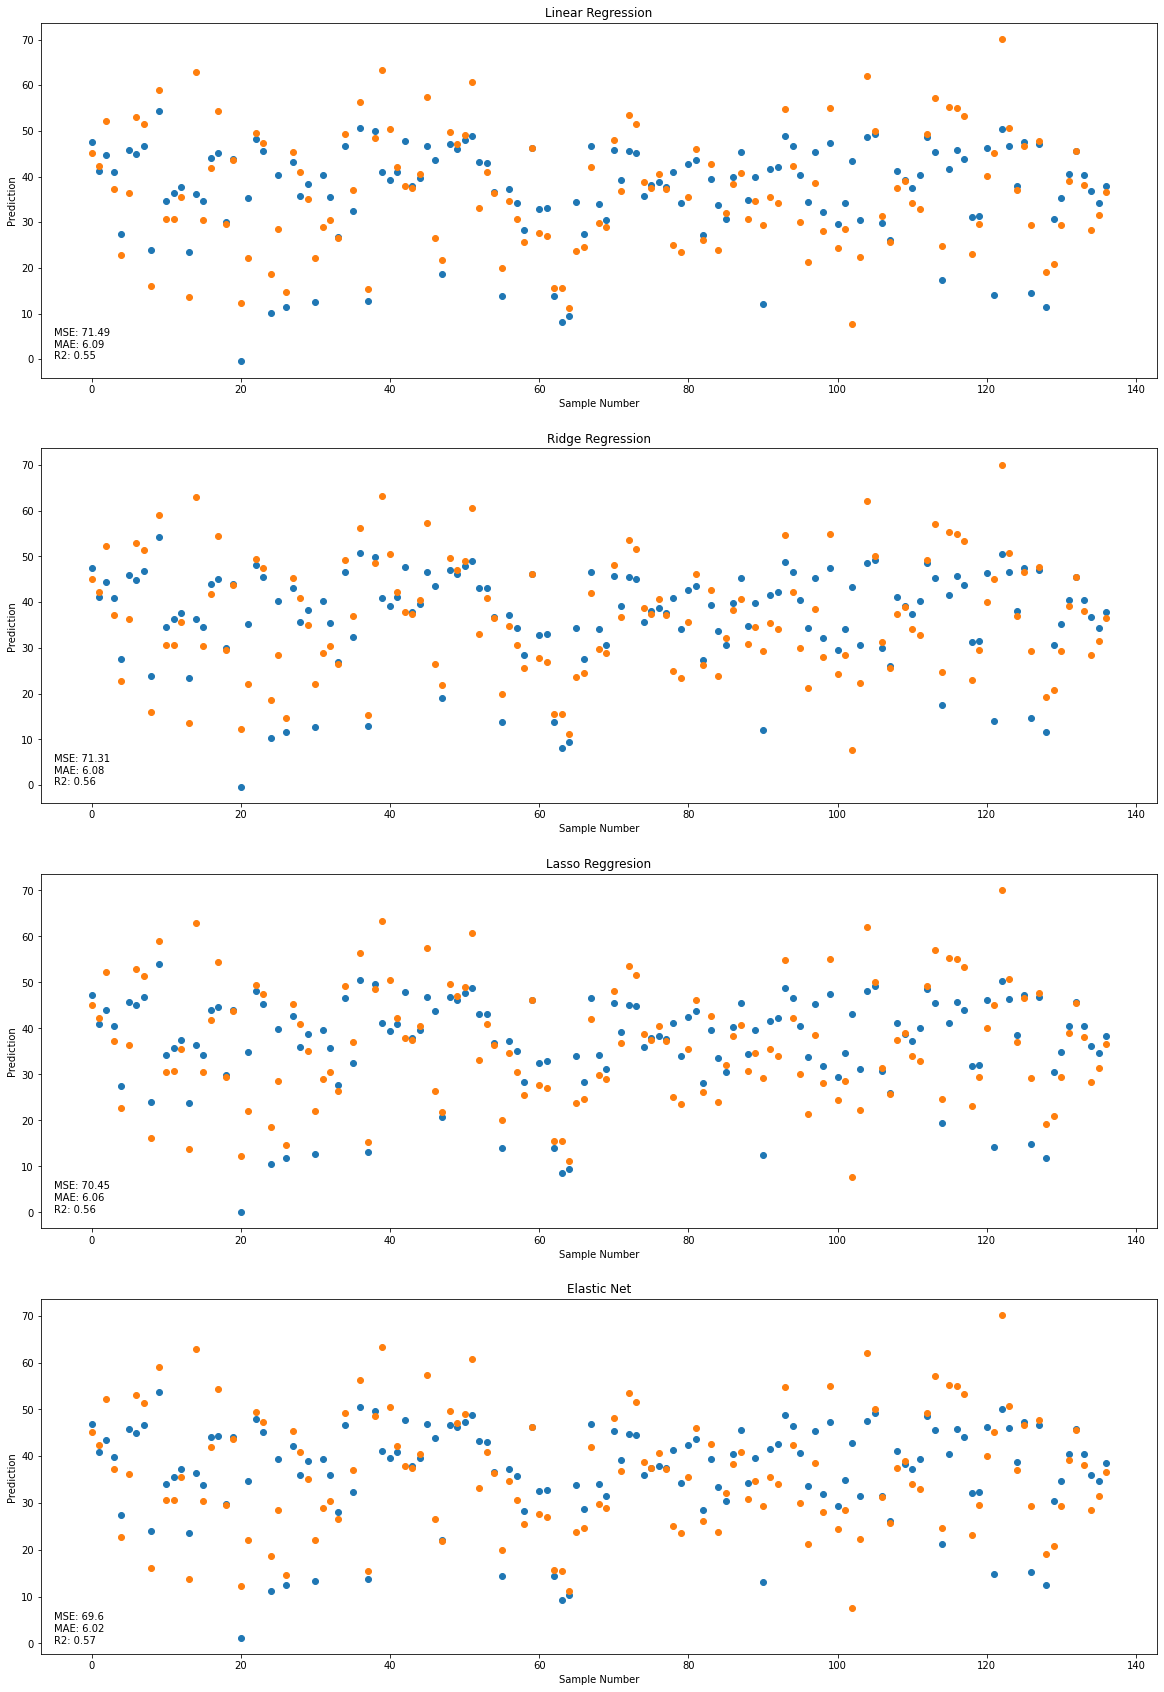

In [28]:
# Ridge Regression
ridge_reg = linear_model.Ridge(alpha = 1, solver = "cholesky")
ridge_reg.fit(X_train, y_train)
y_hat2 = ridge_reg.predict(X_test)

# LASSO 
lasso_reg = linear_model.Lasso(alpha = 0.1)
lasso_reg.fit(X_train, y_train)
y_hat3 = lasso_reg.predict(X_test)

# Elastic Net
elastic_net = linear_model.ElasticNet(alpha = 0.1, l1_ratio = 0.5)
elastic_net.fit(X_train, y_train)

y_hat4 = elastic_net.predict(X_test)

ay_hat = np.array([y_hat, y_hat2, y_hat3, y_hat4])
labels = ["Linear Regression", "Ridge Regression", "Lasso Reggresion", "Elastic Net"]

fig, ax = plt.subplots(ay_hat.shape[0], 1, figsize = (20,30))

for i in range(ay_hat.shape[0]):
    ax[i].scatter(range(X_test.shape[0]), ay_hat[i])
    ax[i].set_title(labels[i])
    ax[i].set_xlabel("Sample Number")
    ax[i].set_ylabel("Prediction")
    ax[i].scatter(range(X_test.shape[0]), y_test)
    
    MSE = np.round((1/X_test.shape[0])*sum((ay_hat[i] - y_test)**2),2)
    MAE = np.round((1/X_test.shape[0])*sum(np.abs((ay_hat[i] - y_test))),2)
    R2 = np.round(sk.metrics.r2_score(y_test, ay_hat[i]),2)
    errors = "MSE: " + str(MSE) + "\n" + "MAE: " + str(MAE) + "\n" + "R2: " + str(R2)

    ax[i].text(-5,0, errors)


None of the variations described above make a significant difference on the ability of our model to correctly predict outcomes. All three variations are better than simple regression and elastic net performs the best according to the MSE, MAE and $R^2$ metrics. This is in line with the expected result because elastic net is a combination of LASSO and ridge regression and attempts to minimize the impact of insignificant features.

---

Linear regression does not perform well on this dataset. While this model might be useful in general analysis, linear regression is not well suited for data with large outliers and variance. Testing multiple models and variations is important during the initial stages of developing a machine learning project. 

## Phase 4: Model Comparison

The scores for classification models are below:
- Linear Regression (best of variations: Elastic Net): 
    - MSE = 69.6
    - MAE = 6.02
- Gradient Descent: 
    - MSE = 70.32
    - MAE = 6.0
- K-Nearest Neighbors Regression (KNN)*: 
    - MSE = 71.49
    - MAE = 6.0
- Tree Regression*: 
    - MSE = 59.15
    - MAE = 5.47
- Support Vector Machine Regression (SVMR)*: 
    - MSE = 72.68
    - MAE = 6.13
- Voting Regressor: 
    - MSE = 44.26
    - MAE = 4.51
- Random Forests
    - MSE = 41.1
    - MAE = 4.21


Outside of the ensemble leaerning models, the best performing model was the Decision Tree Regression model with an MSE of 59.15 and an MAE of 5.47. The next best performing model is the linear regression model, followed by gradient descent, KNN, then finally the support vector machine. It is interesting the linear regression model and the gradient descent model have different MSE and MAE values, however this can be due the randomness when shuffling and splitting the data. 

The Tree Regression model is the best performing, fastest training, and is also easily understood. If we were selecting a model to pursue to further enhance the project, we would select the tree regression model.

The best overall models are the ensemble models. The random forests outperform the voting regressor (just as the pure decision tree outperformed the rest), however both are substantially better than any other model discussed. This is as expected as ensemble learning is expected to mitigate the errors from any individual model. While we would have to train and fit each model, increasing our computational and resource costs, the benifits are significant. For this project, we do not have issues with resources or computation time and would therefore use the random forest model. 